In [7]:
# Imports các thư viện cần thiết
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import warnings
import cv2
from sklearn.cluster import KMeans
from skimage.filters import sobel
from sklearn.utils import class_weight
from skimage import color

# Bỏ qua các cảnh báo không quan trọng
warnings.filterwarnings('ignore')

# Thiết lập GPU để tránh lỗi hết bộ nhớ
gpus = tf.config.list_physical_devices('GPU')
print("Các thiết bị GPU có sẵn: ", gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✓ Đã bật chế độ memory growth cho tất cả GPU.")
    except RuntimeError as e:
        print(f"Lỗi khi cấu hình GPU: {e}")

print("Hoàn tất cài đặt và imports!")


Các thiết bị GPU có sẵn:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
✓ Đã bật chế độ memory growth cho tất cả GPU.
Hoàn tất cài đặt và imports!


CÁC HẰNG SỐ VÀ CẤU HÌNH

In [8]:
# Cấu hình pipeline dữ liệu
IMG_SIZE = (300, 300)
BATCH_SIZE = 32
DATA_DIR = '/kaggle/input/skin-disease-edition'  

# Cấu hình phân chia dữ liệu (tính theo phần trăm)
TRAIN_LABELED_RATIO = 0.10     # 10% ảnh có nhãn để huấn luyện ban đầu
VAL_RATIO = 0.10               # 10% ảnh để validation
TEST_RATIO = 0.15              # 15% ảnh để test
# Phần còn lại (65%) là tập Unlabeled

# Cấu hình cho việc huấn luyện
EPOCHS_TEACHER = 30            # Số epochs để huấn luyện Teacher Model
EPOCHS_STUDENT = 30            # Số epochs để huấn luyện Student Model
CONFIDENCE_THRESHOLD = 0.9     # Ngưỡng tin cậy để tạo nhãn giả (pseudo-label)

print("Các hằng số và cấu hình đã được thiết lập.")


Các hằng số và cấu hình đã được thiết lập.


=== Bắt đầu phân tích dữ liệu ===

Tổng số lớp bệnh: 10
Tổng số ảnh: 69803

Phân phối số lượng ảnh theo từng bệnh:
                                                         Disease  Count
                                 5. Melanocytic Nevi (NV) - 7970   7000
                                              2. Melanoma 15.75k   6993
           10. Warts Molluscum and other Viral Infections - 2103   6991
          8. Seborrheic Keratoses and other Benign Tumors - 1.8k   6988
9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k   6981
                              4. Basal Cell Carcinoma (BCC) 3323   6978
                                                  1. Eczema 1677   6976
   7. Psoriasis pictures Lichen Planus and related diseases - 2k   6976
                                    3. Atopic Dermatitis - 1.25k   6962
                     6. Benign Keratosis-like Lesions (BKL) 2624   6958


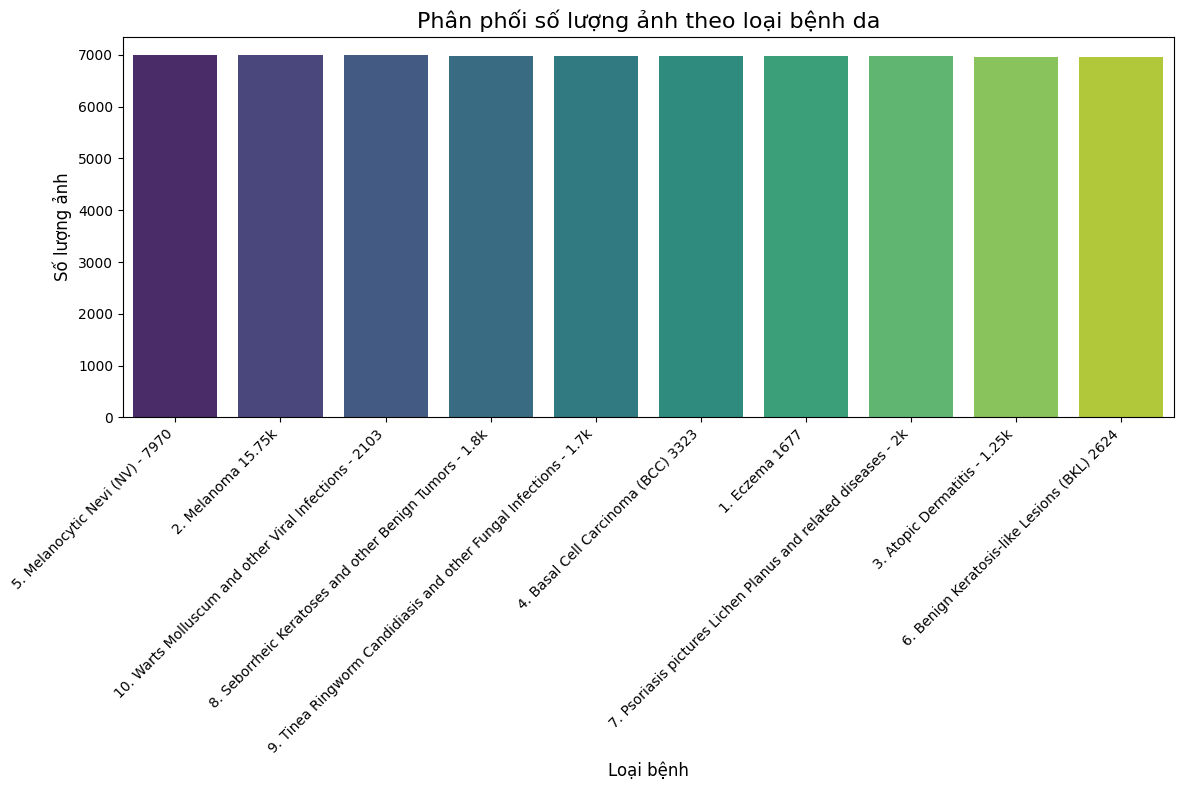

In [9]:
print("=== Bắt đầu phân tích dữ liệu ===")

# Lấy danh sách tên các lớp (thư mục con)
class_names = sorted([name for name in os.listdir(DATA_DIR) if os.path.isdir(DATA_DIR)])
num_classes = len(class_names)

# Đếm số lượng ảnh trong mỗi lớp
class_counts = {}
for class_name in class_names:
    class_dir = os.path.join(DATA_DIR, class_name)
    count = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    class_counts[class_name] = count

# Tạo DataFrame để hiển thị thống kê
df_stats = pd.DataFrame(list(class_counts.items()), columns=['Disease', 'Count'])
df_stats = df_stats.sort_values('Count', ascending=False)

# In ra các thông số
print(f"\nTổng số lớp bệnh: {num_classes}")
print(f"Tổng số ảnh: {sum(class_counts.values())}")
print("\nPhân phối số lượng ảnh theo từng bệnh:")
print(df_stats.to_string(index=False))

# Vẽ biểu đồ phân phối dữ liệu
plt.figure(figsize=(12, 8))
sns.barplot(data=df_stats, x='Disease', y='Count', palette='viridis')
plt.title('Phân phối số lượng ảnh theo loại bệnh da', fontsize=16)
plt.xlabel('Loại bệnh', fontsize=12)
plt.ylabel('Số lượng ảnh', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

CHUẨN BỊ VÀ PHÂN CHIA DỮ LIỆU

In [10]:
from sklearn.model_selection import train_test_split

print("=== Bắt đầu thu thập và phân chia dữ liệu ===")

# Tạo ánh xạ từ tên lớp sang chỉ số (index)
class_to_idx = {name: i for i, name in enumerate(class_names)}

# Thu thập tất cả đường dẫn file và nhãn tương ứng
all_filepaths = []
all_labels = []
for class_name in class_names:
    class_dir = os.path.join(DATA_DIR, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_filepaths.append(os.path.join(class_dir, fname))
            all_labels.append(class_to_idx[class_name])

all_filepaths = np.array(all_filepaths)
all_labels = np.array(all_labels)

print(f"Tổng số ảnh đã thu thập: {len(all_filepaths)}")

# --- Bắt đầu quá trình phân chia theo phần trăm ---
# 1. Tách tập TEST trước
train_val_unlabeled_paths, test_paths, train_val_unlabeled_labels, test_labels = train_test_split(
    all_filepaths, all_labels,
    test_size=TEST_RATIO,
    stratify=all_labels,
    random_state=42
)

# 2. Tách tập VALIDATION từ phần còn lại
train_unlabeled_paths, val_paths, train_unlabeled_labels, val_labels = train_test_split(
    train_val_unlabeled_paths, train_val_unlabeled_labels,
    test_size=VAL_RATIO / (1 - TEST_RATIO),  # Chia theo phần trăm còn lại
    stratify=train_val_unlabeled_labels,
    random_state=42
)

# 3. Tách tập TRAIN (có nhãn) từ phần còn lại, phần còn lại là UNLABELED
train_paths, unlabeled_paths, train_labels, unlabeled_labels = train_test_split(
    train_unlabeled_paths, train_unlabeled_labels,
    test_size=1 - TRAIN_LABELED_RATIO / (1 - TEST_RATIO - VAL_RATIO),  # chia phần còn lại
    stratify=train_unlabeled_labels,
    random_state=42
)

print("\n--- Kết quả phân chia dữ liệu ---")
print(f"Tập Train (có nhãn):        {len(train_paths):>5} ảnh")
print(f"Tập Validation:             {len(val_paths):>5} ảnh")
print(f"Tập Test:                   {len(test_paths):>5} ảnh")
print(f"Tập Unlabeled (không nhãn): {len(unlabeled_paths):>5} ảnh")


=== Bắt đầu thu thập và phân chia dữ liệu ===
Tổng số ảnh đã thu thập: 69803

--- Kết quả phân chia dữ liệu ---
Tập Train (có nhãn):         6980 ảnh
Tập Validation:              6981 ảnh
Tập Test:                   10471 ảnh
Tập Unlabeled (không nhãn): 45371 ảnh


TẠO PIPELINE DỮ LIỆU TF.DATA

In [12]:
print("=== Định nghĩa các hàm tiền xử lý và tạo pipeline tf.data ===")

# Hàm đọc và resize ảnh
def parse_image(filepath, label=None):
    image = tf.io.read_file(filepath)
    image = tf.io.decode_image(image, channels=3, expand_animations=False)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, IMG_SIZE)
    if label is None:
        return image
    return image, label

# Hàm tăng cường dữ liệu (data augmentation)
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    image = tf.image.random_crop(image, size=[IMG_SIZE[0], IMG_SIZE[1], 3])
    image = tf.image.random_brightness(image, max_delta=0.15)
    image = tf.image.random_contrast(image, lower=0.85, upper=1.15)
    return image, label

# Hàm tạo tf.data.Dataset
def create_tf_dataset(filepaths, labels=None, is_unlabeled=False, batch_size=BATCH_SIZE, augment=False, shuffle=True):
    if is_unlabeled:
        dataset = tf.data.Dataset.from_tensor_slices(filepaths)
        dataset = dataset.map(lambda x: parse_image(x), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
        dataset = dataset.map(lambda x, y: parse_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1024)
    if augment and not is_unlabeled:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Tạo các dataset cho quá trình huấn luyện và đánh giá
train_dataset = create_tf_dataset(train_paths, train_labels, augment=True)
val_dataset = create_tf_dataset(val_paths, val_labels, shuffle=False)
test_dataset = create_tf_dataset(test_paths, test_labels, shuffle=False)
unlabeled_dataset = create_tf_dataset(unlabeled_paths, is_unlabeled=True, shuffle=False)

print("\n✓ Đã tạo xong các đối tượng tf.data.Dataset:")
print(f"- train_dataset")
print(f"- val_dataset")
print(f"- test_dataset")
print(f"- unlabeled_dataset")

=== Định nghĩa các hàm tiền xử lý và tạo pipeline tf.data ===

✓ Đã tạo xong các đối tượng tf.data.Dataset:
- train_dataset
- val_dataset
- test_dataset
- unlabeled_dataset


XÂY DỰNG VÀ HUẤN LUYỆN TEACHER MODEL (BASELINE)

In [15]:
print("=== Bắt đầu xây dựng Teacher Model ===")

# Sử dụng EfficientNetB3 làm nền tảng
base_model = tf.keras.applications.EfficientNetB3(
    weights='imagenet',
    include_top=False,
    pooling='avg'
)

# Tạo model
inputs = tf.keras.Input(shape=(300, 300, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
teacher_model = tf.keras.Model(inputs, outputs)

print("\n✓ Kiến trúc Teacher Model đã được tạo:")
teacher_model.summary()

# =============================
# GIAI ĐOẠN 1: TRAIN HEAD
# =============================
print("\n--- GIAI ĐOẠN 1: TRAIN HEAD ---")
base_model.trainable = False

teacher_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_head = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        verbose=1
    )
]

history_head = teacher_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks_head,
    verbose=1
)

# =============================
# GIAI ĐOẠN 2: FINE-TUNING
# =============================
print("\n--- GIAI ĐOẠN 2: FINE-TUNING ---")
base_model.trainable = True

fine_tune_at = len(base_model.layers) - 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

teacher_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_finetune = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        verbose=1
    )
]

history_finetune = teacher_model.fit(
    train_dataset,
    validation_data=val_dataset,
    initial_epoch=len(history_head.history['accuracy']),
    epochs=50,
    callbacks=callbacks_finetune,
    verbose=1
)

print("\n✓ Teacher Model đã được huấn luyện xong hoàn toàn.")


=== Bắt đầu xây dựng Teacher Model ===

✓ Kiến trúc Teacher Model đã được tạo:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,575,609 (44.16 MB)

 Trainable params: 11,488,306 (43.82 MB)

 Non-trainable params: 87,303 (341.03 KB)


--- GIAI ĐOẠN 1: TRAIN HEAD ---
Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 122s 365ms/step - accuracy: 0.4585 - loss: 2.2284 - val_accuracy: 0.7182 - val_loss: 1.4567 - learning_rate: 0.0010
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 52s 231ms/step - accuracy: 0.6751 - loss: 1.5258 - val_accuracy: 0.7364 - val_loss: 1.2795 - learning_rate: 0.0010
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 51s 226ms/step - accuracy: 0.7175 - loss: 1.3307 - val_accuracy: 0.8005 - val_loss: 1.0991 - learning_rate: 0.0010
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 52s 228ms/step - accuracy: 0.7329 - loss: 1.2395 - val_accuracy: 0.8208 - val_loss: 1.0331 - learning_rate: 0.0010
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 51s 227ms/step - accuracy: 0.7588 - loss: 1.1410 - val_accuracy: 0.8211 - val_loss: 0.9950 - learning_rate: 0.0010
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 52s 227ms/step - accuracy: 0.7754 - loss: 1.0991 - val_accuracy: 0.8368 - val_loss: 0.9508 - learning_rate: 0.0010
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━

ĐÁNH GIÁ TEACHER MODEL (BASELINE)

=== Bắt đầu đánh giá Teacher Model trên tập test ===

Kết quả Teacher Model:
 - Loss: 0.5507
 - Accuracy: 0.8995

Classification Report (Teacher Model):
                                                                  precision    recall  f1-score   support

                                                  1. Eczema 1677      0.889     0.891     0.890      1047
           10. Warts Molluscum and other Viral Infections - 2103      0.879     0.880     0.879      1049
                                              2. Melanoma 15.75k      0.961     0.939     0.950      1049
                                    3. Atopic Dermatitis - 1.25k      0.901     0.913     0.907      1044
                              4. Basal Cell Carcinoma (BCC) 3323      0.916     0.942     0.929      1047
                                 5. Melanocytic Nevi (NV) - 7970      0.872     0.903     0.887      1050
                     6. Benign Keratosis-like Lesions (BKL) 2624      0.913     0.883     0.898      104

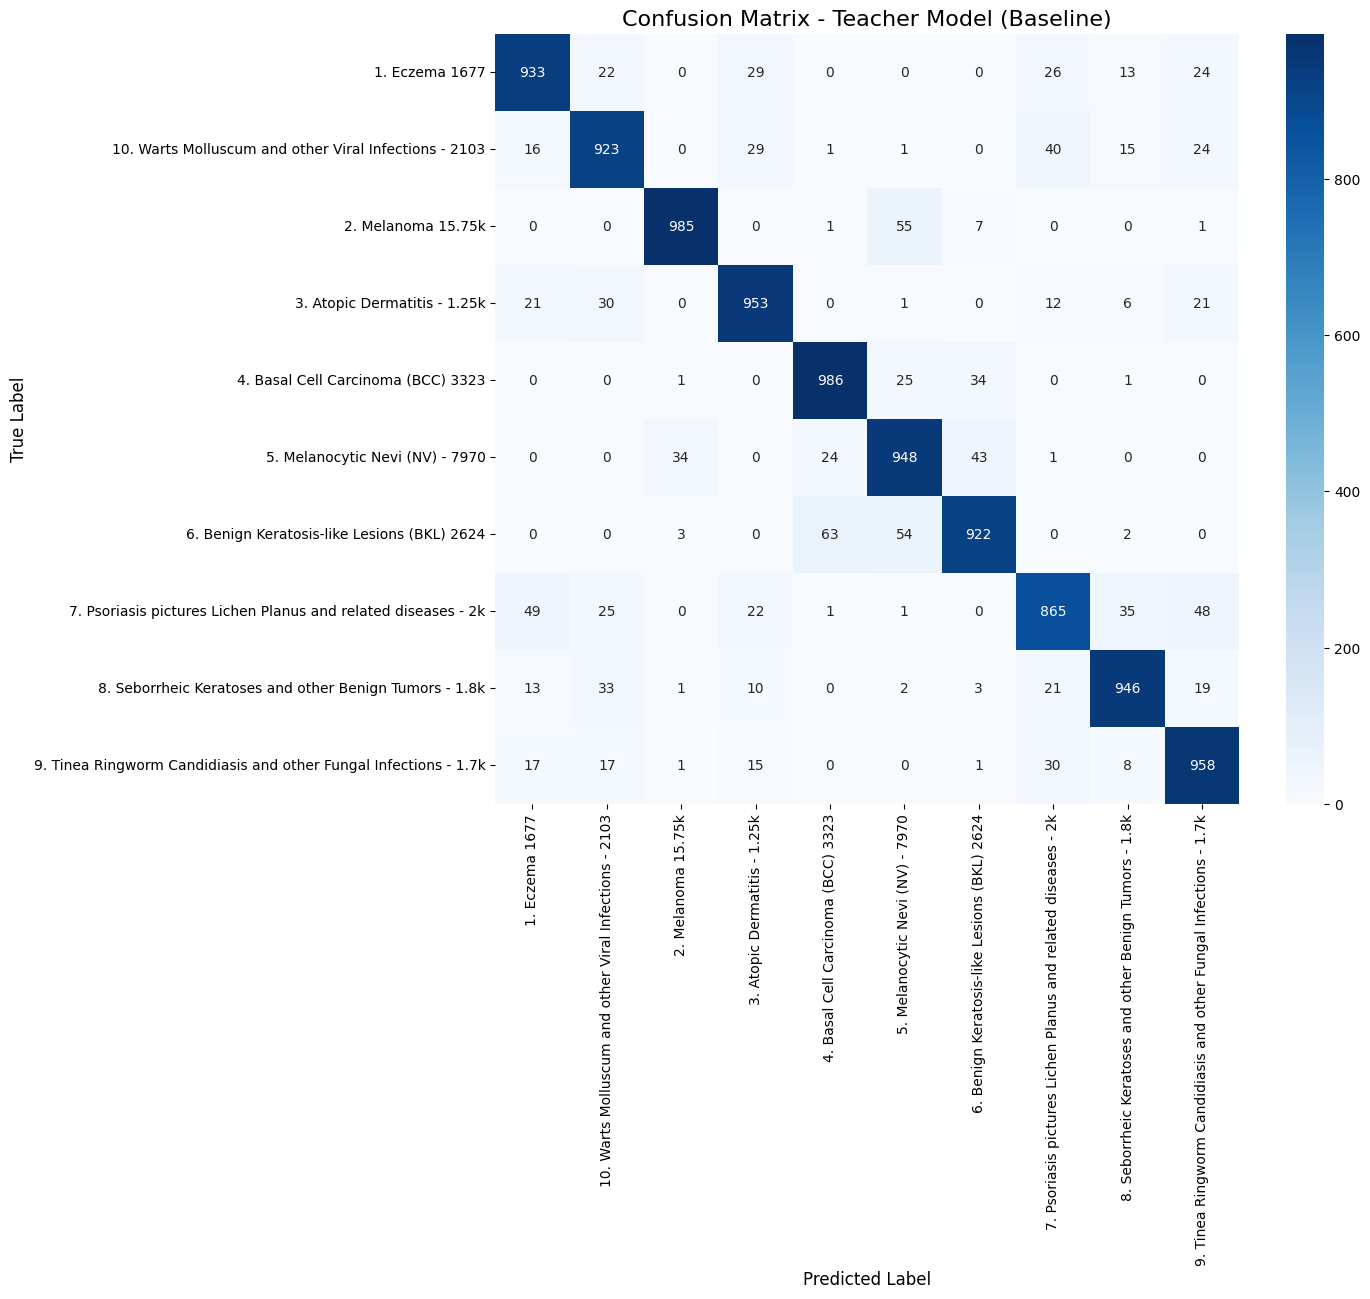

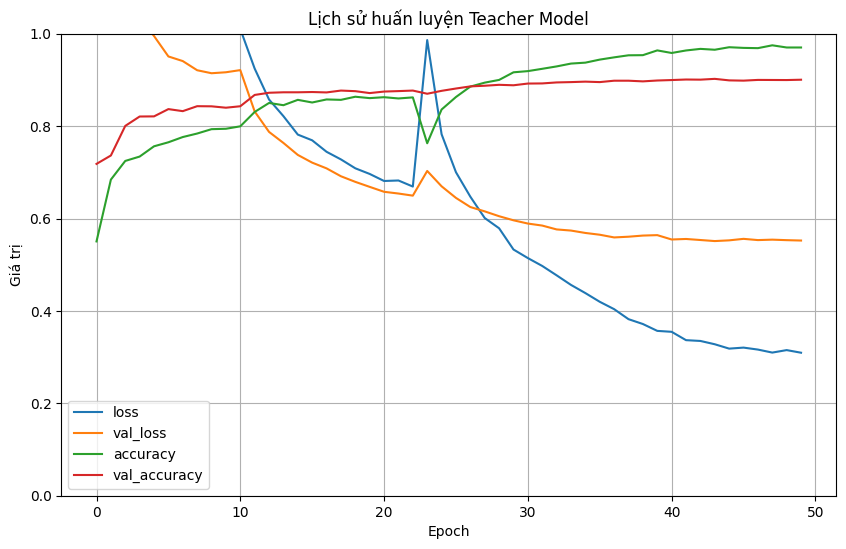

In [17]:
print("=== Bắt đầu đánh giá Teacher Model trên tập test ===")

# --- Đánh giá tổng thể ---
loss, baseline_accuracy = teacher_model.evaluate(test_dataset, verbose=0)
print(f"\nKết quả Teacher Model:")
print(f" - Loss: {loss:.4f}")
print(f" - Accuracy: {baseline_accuracy:.4f}")

# --- Dự đoán để phân tích ---
y_true_teacher = []
y_pred_teacher_probs = []

for images, labels in test_dataset:
    y_true_teacher.extend(labels.numpy())
    y_pred_teacher_probs.extend(teacher_model.predict(images, verbose=0))

y_pred_teacher = np.argmax(y_pred_teacher_probs, axis=1)

# --- Classification Report ---
print("\nClassification Report (Teacher Model):")
print(classification_report(y_true_teacher, y_pred_teacher, target_names=class_names, digits=3))

# --- Vẽ Confusion Matrix ---
cm = confusion_matrix(y_true_teacher, y_pred_teacher)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Teacher Model (Baseline)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# --- Vẽ lịch sử huấn luyện (gộp cả 2 giai đoạn) ---
full_history = {
    'loss': history_head.history['loss'] + history_finetune.history['loss'],
    'val_loss': history_head.history['val_loss'] + history_finetune.history['val_loss'],
    'accuracy': history_head.history['accuracy'] + history_finetune.history['accuracy'],
    'val_accuracy': history_head.history['val_accuracy'] + history_finetune.history['val_accuracy']
}

pd.DataFrame(full_history).plot(figsize=(10, 6))
plt.grid(True)
plt.title("Lịch sử huấn luyện Teacher Model")
plt.xlabel("Epoch")
plt.ylabel("Giá trị")
plt.gca().set_ylim(0, 1)
plt.show()


TẠO NHÃN GIẢ (PSEUDO-LABELING)

In [18]:
print(f"=== Bắt đầu tạo nhãn giả với ngưỡng tin cậy >= {CONFIDENCE_THRESHOLD} ===")

# Danh sách để lưu kết quả
pseudo_paths_list = []
pseudo_labels_list = []
pseudo_confidences_list = []

# unlabeled_dataset bây giờ chỉ chứa đường dẫn file (chưa load ảnh)
# Tạo một dataset chỉ chứa đường dẫn file từ mảng unlabeled_paths của bạn
path_ds = tf.data.Dataset.from_tensor_slices(unlabeled_paths)

# Hàm để load ảnh từ đường dẫn
def load_image_for_prediction(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
    return img, path # Trả về cả ảnh và đường dẫn

# Tạo dataset để dự đoán theo batch
predict_ds = path_ds.map(load_image_for_prediction, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)

# Lặp qua từng batch để dự đoán -> TIẾT KIỆM RAM
for image_batch, path_batch in predict_ds:
    predictions = teacher_model.predict_on_batch(image_batch)

    confidences = tf.reduce_max(predictions, axis=1)
    labels = tf.argmax(predictions, axis=1)

    # Lọc trong batch hiện tại
    for i in range(len(confidences)):
        if confidences[i] >= CONFIDENCE_THRESHOLD:
            # Lưu đường dẫn (dưới dạng bytes) và nhãn
            pseudo_paths_list.append(path_batch[i].numpy())
            pseudo_labels_list.append(labels[i].numpy())
            pseudo_confidences_list.append(confidences[i].numpy())

# Chuyển đổi lại thành mảng NumPy
pseudo_paths = np.array(pseudo_paths_list)
pseudo_labels = np.array(pseudo_labels_list)
max_probs_high_confidence = np.array(pseudo_confidences_list)

print(f"\n--- Kết quả ---")
print(f"Đã tạo ra {len(pseudo_paths)} nhãn giả từ {len(unlabeled_paths)} ảnh không nhãn.")
# ... các lệnh print khác ...
print(f"Tỷ lệ chọn: {len(pseudo_paths) / len(unlabeled_paths) * 100:.2f}%")
if len(pseudo_paths) > 0:
    print(f"Độ tin cậy trung bình của các nhãn giả: {np.mean(max_probs_high_confidence):.3f}")

=== Bắt đầu tạo nhãn giả với ngưỡng tin cậy >= 0.9 ===

--- Kết quả ---
Đã tạo ra 37984 nhãn giả từ 45371 ảnh không nhãn.
Tỷ lệ chọn: 83.72%
Độ tin cậy trung bình của các nhãn giả: 0.993


HUẤN LUYỆN STUDENT MODEL

In [19]:
if len(pseudo_paths) > 0:
    print("\n[BƯỚC 2] Chuẩn bị dữ liệu và huấn luyện Student Model")

    # === Tạo Dataset từ dữ liệu gốc và nhãn giả ===
    print("\n--- Đang tạo pipeline dữ liệu cho Student Model ---")
    original_train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    pseudo_ds = tf.data.Dataset.from_tensor_slices((pseudo_paths, pseudo_labels))

    student_train_ds_paths = original_train_ds.concatenate(pseudo_ds)
    total_student_train_size = len(train_paths) + len(pseudo_paths)
    print(f"Tổng số dữ liệu huấn luyện cho Student: {total_student_train_size} ảnh")

    def load_and_process_student_data(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [IMG_SIZE[0], IMG_SIZE[1]])
        image, label = augment_image(image, label)
        return image, label

    student_train_dataset = student_train_ds_paths.shuffle(buffer_size=total_student_train_size) \
                                                  .map(load_and_process_student_data, num_parallel_calls=tf.data.AUTOTUNE) \
                                                  .batch(BATCH_SIZE) \
                                                  .prefetch(tf.data.AUTOTUNE)

    # === Tính toán class weights ===
    print("\n--- Đang tính toán class weights cho Student Model ---")
    combined_train_labels = np.concatenate([train_labels, pseudo_labels])
    student_class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(combined_train_labels),
        y=combined_train_labels
    )
    student_class_weights_dict = dict(enumerate(student_class_weights))
    print("Class weights mới:", student_class_weights_dict)

    # === Xây dựng Student Model ===
    print("\n--- Xây dựng Student Model (Kiến trúc giống hệt Teacher) ---")
    base_model_student = tf.keras.applications.EfficientNetB3(weights='imagenet', include_top=False, pooling='avg')
    inputs_student = tf.keras.Input(shape=(300, 300, 3))
    x_student = tf.keras.applications.efficientnet.preprocess_input(inputs_student)
    x_student = base_model_student(x_student, training=False)
    x_student = tf.keras.layers.Dropout(0.4)(x_student)
    x_student = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x_student)
    x_student = tf.keras.layers.Dropout(0.4)(x_student)
    outputs_student = tf.keras.layers.Dense(num_classes, activation='softmax')(x_student)
    student_model = tf.keras.Model(inputs_student, outputs_student)

    # === CALLBACKS chung ===
    callbacks_student_head = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
    ]
    callbacks_student_finetune = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=1)
    ]

    # === GIAI ĐOẠN 1: Train HEAD ===
    print("\n--- STUDENT MODEL: GIAI ĐOẠN 1 - HUẤN LUYỆN HEAD ---")
    base_model_student.trainable = False
    student_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    history_student_head = student_model.fit(
        student_train_dataset,
        validation_data=val_dataset,
        epochs=50,  # Tăng lên từ 10
        class_weight=student_class_weights_dict,
        callbacks=callbacks_student_head,
        verbose=1
    )

    # === GIAI ĐOẠN 2: Fine-tuning ===
    print("\n--- STUDENT MODEL: GIAI ĐOẠN 2 - FINE-TUNING ---")
    base_model_student.trainable = True
    fine_tune_at_student = len(base_model_student.layers) - 50
    for layer in base_model_student.layers[:fine_tune_at_student]:
        layer.trainable = False

    student_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=7e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    history_student_finetune = student_model.fit(
        student_train_dataset,
        validation_data=val_dataset,
        epochs=50,  # tăng từ mặc định
        initial_epoch=len(history_student_head.history['accuracy']),
        callbacks=callbacks_student_finetune,
        class_weight=student_class_weights_dict,
        verbose=1
    )

    # Gộp lịch sử nếu cần vẽ sau
    student_history = {
        'loss': history_student_head.history['loss'] + history_student_finetune.history['loss'],
        'val_loss': history_student_head.history['val_loss'] + history_student_finetune.history['val_loss'],
        'accuracy': history_student_head.history['accuracy'] + history_student_finetune.history['accuracy'],
        'val_accuracy': history_student_head.history['val_accuracy'] + history_student_finetune.history['val_accuracy']
    }

    print("\n✓ Đã huấn luyện xong Student Model.")

else:
    print("\n[!!!] KHÔNG CÓ ĐỦ NHÃN GIẢ được tạo ra. Bỏ qua việc huấn luyện Student Model.")
    print("Sử dụng Teacher Model làm model cuối cùng.")
    student_model = teacher_model
    student_history = {
        'loss': history_head.history['loss'] + history_finetune.history['loss'],
        'val_loss': history_head.history['val_loss'] + history_finetune.history['val_loss'],
        'accuracy': history_head.history['accuracy'] + history_finetune.history['accuracy'],
        'val_accuracy': history_head.history['val_accuracy'] + history_finetune.history['val_accuracy']
    }



[BƯỚC 2] Chuẩn bị dữ liệu và huấn luyện Student Model

--- Đang tạo pipeline dữ liệu cho Student Model ---
Tổng số dữ liệu huấn luyện cho Student: 44964 ảnh

--- Đang tính toán class weights cho Student Model ---
Class weights mới: {0: 0.9994220937986219, 1: 1.0214447978191732, 2: 0.9272839760775418, 3: 0.9759930540481876, 4: 0.9609745672152169, 5: 1.0415566365531619, 6: 1.014301827205053, 7: 1.0990955756538743, 8: 0.9738791423001949, 9: 1.0059060402684563}

--- Xây dựng Student Model (Kiến trúc giống hệt Teacher) ---

--- STUDENT MODEL: GIAI ĐOẠN 1 - HUẤN LUYỆN HEAD ---
Epoch 1/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 256s 152ms/step - accuracy: 0.6905 - loss: 1.5014 - val_accuracy: 0.8327 - val_loss: 0.9596 - learning_rate: 0.0010
Epoch 2/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 185s 131ms/step - accuracy: 0.8533 - loss: 0.8673 - val_accuracy: 0.8469 - val_loss: 0.9055 - learning_rate: 0.0010
Epoch 3/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 184s 131ms/step - accuracy: 0.8693 - loss: 0.8286 - val_accurac

ĐÁNH GIÁ STUDENT MODEL VÀ SO SÁNH KẾT QUẢ

=== Bắt đầu đánh giá Student Model trên tập test ===

Kết quả Student Model:
 - Loss: 0.4773
 - Accuracy: 0.9065

Classification Report (Student Model):
                                                                  precision    recall  f1-score   support

                                                  1. Eczema 1677      0.886     0.902     0.894      1047
           10. Warts Molluscum and other Viral Infections - 2103      0.869     0.888     0.879      1049
                                              2. Melanoma 15.75k      0.976     0.951     0.963      1049
                                    3. Atopic Dermatitis - 1.25k      0.895     0.910     0.902      1044
                              4. Basal Cell Carcinoma (BCC) 3323      0.927     0.949     0.938      1047
                                 5. Melanocytic Nevi (NV) - 7970      0.890     0.939     0.914      1050
                     6. Benign Keratosis-like Lesions (BKL) 2624      0.934     0.888     0.910      104

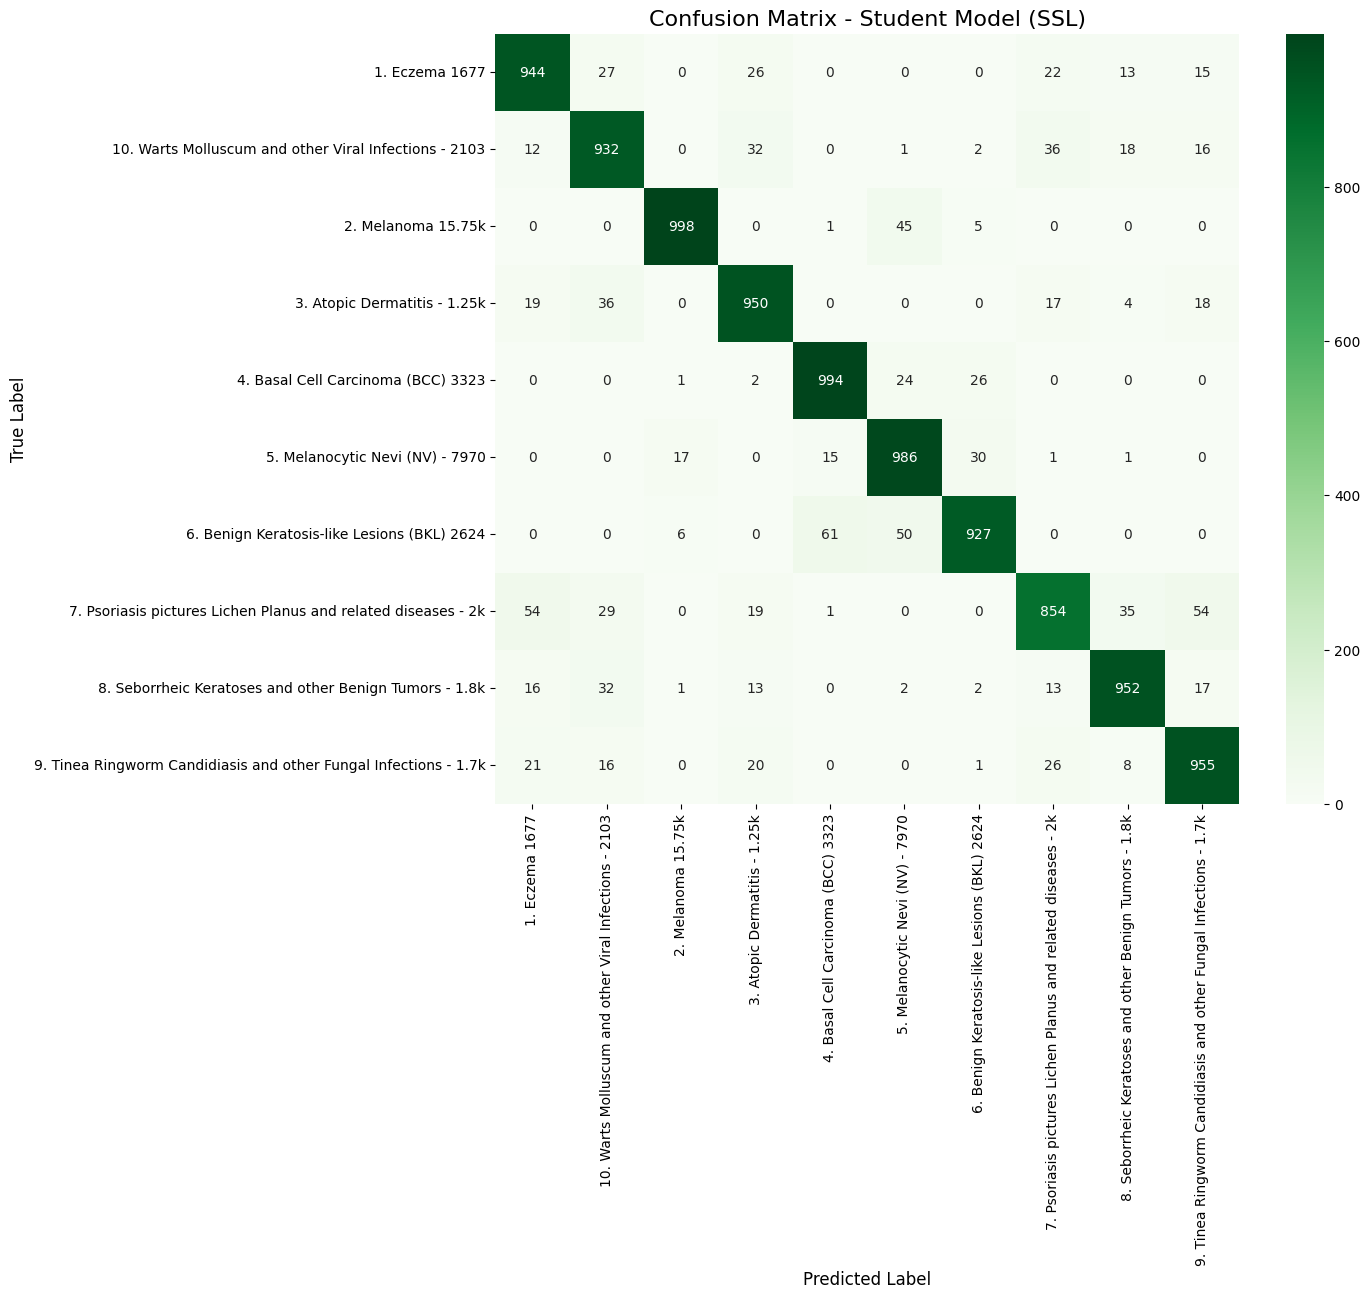


 KẾT LUẬN CUỐI CÙNG
Accuracy Baseline (Teacher Model): 0.8995
Accuracy Final (Student Model):  0.9065
--------------------------------------------------
✓ Cải thiện: +0.78%
=> Học bán giám sát (Pseudo-Labeling) đã thành công!


In [20]:
if len(pseudo_paths) > 0:
    print("=== Bắt đầu đánh giá Student Model trên tập test ===")

    # Đánh giá chung
    loss_student, final_accuracy = student_model.evaluate(test_dataset, verbose=0)
    print(f"\nKết quả Student Model:")
    print(f" - Loss: {loss_student:.4f}")
    print(f" - Accuracy: {final_accuracy:.4f}")

    # Lấy dự đoán chi tiết để vẽ confusion matrix
    y_true_student = []
    y_pred_student_probs = []
    for images, labels in test_dataset:
        y_true_student.extend(labels.numpy())
        y_pred_student_probs.extend(student_model.predict(images, verbose=0))
    y_pred_student = np.argmax(y_pred_student_probs, axis=1)

    # In classification report
    print("\nClassification Report (Student Model):")
    print(classification_report(y_true_student, y_pred_student, target_names=class_names, digits=3))

    # Vẽ Confusion Matrix
    cm_student = confusion_matrix(y_true_student, y_pred_student)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_student, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Student Model (SSL)', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

# --- SO SÁNH KẾT QUẢ CUỐI CÙNG ---
print("\n" + "="*50)
print(" KẾT LUẬN CUỐI CÙNG")
print("="*50)
print(f"Accuracy Baseline (Teacher Model): {baseline_accuracy:.4f}")
print(f"Accuracy Final (Student Model):  {final_accuracy:.4f}")
print("-" * 50)

if final_accuracy > baseline_accuracy:
    improvement = (final_accuracy - baseline_accuracy) / baseline_accuracy * 100
    print(f"✓ Cải thiện: +{improvement:.2f}%")
    print("=> Học bán giám sát (Pseudo-Labeling) đã thành công!")
else:
    print("=> Không có sự cải thiện đáng kể.")
    print("Gợi ý: Thử giảm `CONFIDENCE_THRESHOLD` hoặc tăng số `EPOCHS`.")
print("="*50)

In [21]:
import datetime

# Tạo tên file theo thời gian để tránh ghi đè
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = "student_model" if 'student_model' in globals() else "teacher_model"
file_path = f"{model_name}_{timestamp}.h5"
file_path2 = f"{model_name}_{timestamp}.keras"
# Lưu mô hình
student_model.save(file_path) if model_name == "student_model" else teacher_model.save(file_path)
student_model.save(file_path2) if model_name == "student_model" else teacher_model.save(file_path2)
print(f"✓ Đã lưu mô hình vào file: {file_path} | {file_path2}")



✓ Đã lưu mô hình vào file: student_model_20250613-133547.h5 | student_model_20250613-133547.keras
